# **Table of Contents**
* [Explore & Wrangle](#section_20)
* [Assumptions Testing](#section_21)

* [Model Building](#section_22)
    * [LiR](#section_23)
    * [RF](#section_24)
    <br><br>
* [Model Selection](#section_25)
    * [Fitting](#section_26)
    * [Validation](#section_27)
    * [Best Model](#section_28)

In [1]:
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import seaborn           as sns

import warnings
warnings.filterwarnings("ignore")


from   sklearn.linear_model     import   LinearRegression
from   sklearn.ensemble         import   RandomForestRegressor

from   sklearn.model_selection  import   train_test_split , KFold , cross_val_score , GridSearchCV
from   sklearn.metrics          import   mean_squared_error

<a id='section_20'></a>
# Part 1 - **Explore & Wrangle**

In [2]:
df  =  pd.read_csv ('datasets/Lung Capacity.csv')

df.sample(5)

,Age,Height,Gender,Smoke,FEV
562,12,71.0,1,0,4.831
353,11,61.0,1,0,3.058
422,11,67.0,0,0,3.774
48,6,55.0,1,0,1.650
116,7,54.5,0,0,1.698


**Target Col -- FEV**

In [3]:
df.shape

(654, 5)

In [4]:
df.isnull().sum()

Age       0
Height    0
Gender    0
Smoke     0
FEV       0
dtype: int64

<a id='section_21'></a>
# Part 2 - **Assumption Testing**

In [5]:
import statsmodels.api as sm

y  =  df ['FEV']
x  =  df.drop('FEV', axis=1)
xc =  sm.add_constant(x)

model = sm.OLS(y,xc).fit()

## **1. Normality of residuals**

In [6]:
residuals  =  model.resid

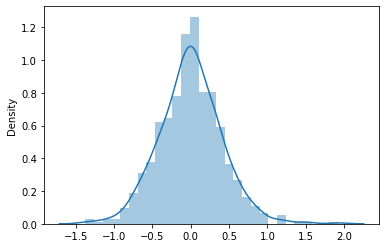

In [7]:
sns.distplot (residuals) ;

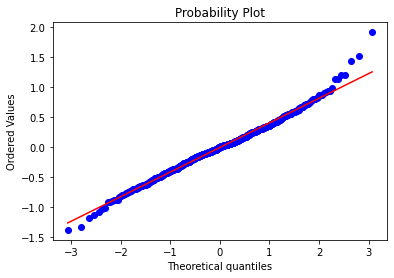

In [8]:
import scipy.stats as stats

stats.probplot (residuals ,  plot=plt)
plt.show()

## **2. Low Multi-collinearity**

In [9]:
from   statsmodels.stats.outliers_influence   import   variance_inflation_factor   as   vif

score  =  [   vif (xc.values, i)        for i in  range(xc.shape[1])     ]

MC     =  pd.DataFrame (  {'VIF':score}  ,   index = xc.columns  )

MC.sort_values (by='VIF',ascending=False)

,VIF
const,191.122030
Age,3.019010
Height,2.829728
Smoke,1.209564
Gender,1.060228


## **3. Homo-scedasticity**

In [10]:
import statsmodels.stats.api as sms

sms.het_goldfeldquandt ( y=residuals , x=xc )

(2.2067933960098842, 1.218254082951857e-12, 'increasing')

> Comments :
        
        * H0 : Equal  var of residuals
        * H1 : Unequal  var of residuals
        * Output : test_statistic , p-value 
> Obs :
        
        * P < alpha
        * Reject Null
        * Hetero-scedastic

## **4. No Auto-correlation**

In [11]:
from  statsmodels.stats.stattools  import  durbin_watson

durbin_watson (residuals)

1.6452015855915552

* Obs
    - Low auto-corr

## **5. Linearity**

In [12]:
import statsmodels.stats.api  as  sms

sms.diagnostic.linear_rainbow (model)

(0.9777868677554196, 0.5802195276905364)

> Comments :
        
        * H0 : Reg is Linear
        * H1 : Reg is not Linear.
        * Output : test_statistic , p-value 
> Obs :
        
        * P > alpha
        * Accept Null
        * Reg is Linear

<a id='section_22'></a>
# Part 3 - **Model Building**

In [13]:
x  =  df.drop ('FEV' , axis=1)
y  =  df ['FEV']

x_train , x_test , y_train , y_test   =   train_test_split (x, y, test_size=0.3, random_state=42)

<a id='section_23'></a>
## **1 - LiR**

In [14]:
lr = LinearRegression()                                       

lr.fit (x_train , y_train)             

LinearRegression()

<a id='section_24'></a>
## **2 - RF**

In [15]:
kf  =  KFold ( n_splits =3 ,  shuffle =True ,  random_state =42 )

In [16]:
RF    =  RandomForestRegressor()

param =  { 'n_estimators':np.arange(1,30) , 'max_depth':np.arange(1,20) }

GS    =  GridSearchCV (RF , param , cv=kf , scoring='r2')

GS.fit (x_train , y_train)

GS.best_params_

{'max_depth': 4, 'n_estimators': 26}

In [17]:
RF = RandomForestRegressor ( n_estimators=26 , max_depth =4 , random_state=0)  

RF.fit (x_train , y_train)

RandomForestRegressor(max_depth=4, n_estimators=26, random_state=0)

<a id='section_25'></a>
# Part 4 - **Model Selection**

In [18]:
models = []

models.append  (( 'LiR'     ,  lr      ))
models.append  (( 'RF'      ,  RF      ))

<a id='section_26'></a>
### **Fitting**

In [19]:
result = []

for i,j in models:

    print(i)
    
    y_train_pred  =  j.predict (x_train)
    y_test_pred   =  j.predict (x_test)
                   
    print  (  ( mean_squared_error  ( y_train , y_train_pred )) **0.5    )                                 
    print  (  ( mean_squared_error  ( y_test  , y_test_pred  )) **0.5    )

LiR
0.4178325114005814
0.3966553899326958
RF
0.36068336215792984
0.40421492824137983


<a id='section_27'></a>
### **Validation**

In [20]:
result = []

for  i,j  in  models:
    
    score = cross_val_score ( j , x_train , y_train , cv =kf, scoring ='r2' )
    
    result.append ( { 'Name': i   ,   'BE': np.mean(1-score)   ,   'VE': np.std(score,ddof=1)  } )                


table = pd.DataFrame(result)
table

,Name,BE,VE
0,LiR,0.256414,0.019606
1,RF,0.244345,0.032488


<a id='section_28'></a>
### **Best Model**

## *Linear Regression*